# BEAT-PD Challenge

Challenge website : https://www.synapse.org/#!Synapse:syn20825169/wiki/596118

Data information : https://www.synapse.org/#!Synapse:syn20825169/wiki/600405


### Ideas/Doubts [Laureano]

VAD like thing to remove unwanted data?
modified MFCC?
X,Y,Z = relative positions or acceleration?

Imp: Predict per person. Maybe UBM like thing and adapt it

In [3]:
# Import required libraries

import pandas as pd
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

# Import required modules
from sklearn.preprocessing import StandardScaler

In [4]:
# Data paths

data_dir='/home/sjoshi/codes/python/BeatPD/data/BeatPD/'
path_save_accelerometer_plots='/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/'
path_save_k_fold_dataframes=data_dir

path_save_silence_removed=data_dir

In [5]:
def define_data_type(data_type):
    # Setup file names

    '''
    data_type={cis , real}

    If data_type is real, data_real_subtype 
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    '''
    if data_type=='cis':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'

    if data_type=='real':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'+data_real_subtype+'/'

    # Display labels
    df_train_label=pd.read_csv(path_train_labels)
    return path_train_data, df_train_label

In [94]:
def plot_accelerometer(data_type, path_accelerometer_plots, path_silence=None):
    # Iterating through all the indexes contained in df_train_label
    for idx in df_train_label.index:
        if path_silence is None:
            df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        else:
            df_train_data=pd.read_csv(path_silence+df_train_label["measurement_id"][idx]+'.csv')
            
        # FIXME: BUG ?  why the following goes to 1000xxx sometimes? It should be max 59xxx
        #display(df_train_data)
        print('measurement_id : ', df_train_label["measurement_id"][idx])
        # Following val_* variables are only used to format a cute title for the charts
        val_subject_id = df_train_label.loc[[idx]]['subject_id'].values[0]
        val_on_off = df_train_label.loc[[idx]]['on_off'].values[0]
        val_dyskinesia = df_train_label.loc[[idx]]['dyskinesia'].values[0]
        val_tremor = df_train_label.loc[[idx]]['tremor'].values[0]
        great_title = "{0} = on_off: {1}, dyskinesia: {2}, tremor: {3}".format(val_subject_id, val_on_off, val_dyskinesia, val_tremor)

        # The time doesn't have the same name depending on the data_type
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        
        # Normalize the data
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        
        df_train_data.plot(x=x_axis_data_type,legend=True, subplots=True,title=great_title)

        # Save plotted graph with the measurement_id as name of the file
        plt.savefig(path_accelerometer_plots+df_train_label["measurement_id"][idx]+'.png')
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()

In [62]:
def prepro_missing_values(df_train_label):
    # Replace NaN values with -1.0 because otherwise plotting triggers an error 
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label

def compute_symptoms_occurences_dataframe(df_train_label):
    df_train_label = prepro_missing_values(df_train_label=df_train_label)
    
    # Group data by subject_id 
    df_train_label_subject_id = df_train_label.groupby('subject_id')

    df_occurences = []
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    
    for key, value in df_train_label_subject_id :
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = df_train_label_subject_id.get_group(key).iloc[:,-3:][symptom].value_counts()

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(({'subject_id': key, 'symptom': symptom, 'symptom_value': symptom_value, 'occurence': symptom_occurence}))

    df_occurences = pd.DataFrame(df_occurences, columns=('subject_id', 'symptom', 'symptom_value', 'occurence'))
    
    return df_occurences, df_train_label_subject_id


In [8]:
'''
This function plots the occurences of symptoms according to subject_id 

Arguments: 
- df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
- df_train_label_subject_id: contains df_train_label grouped by subject_id 
'''
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    
    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = df_occurences.subject_id.nunique() # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 10
    fig, axes = plt.subplots(nrows=nb_subjects_id, ncols=3, figsize=(10,height), sharey=True) # 3 cols for the 3 symptoms
    
    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop 
    # it is incremented
    patient = -1

    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    for key, value in df_train_label_subject_id :
        patient = patient + 1 # value used to position the plots (row)
        symptom_no = 0 # value only used to position the plots (col)
        for symptom in symptoms:
            subject_symptom = ' '.join([str(key), symptom]) # variable used to create a title for each plot
            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(kind='bar',
                                                                                  x=symptom,
                                                                                  title=subject_symptom, 
                                                                                  ax=axes[patient,symptom_no],
                                                                                  sharey=True)
                                                                                  
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1

In [9]:
'''
Filters df_train_label according to a list of measurement_id we are interested in analyzing

Arguments:
- df_train_label: dataframe with labels
- list_measure_id: list of measurement_id 

Returns:
- df_train_label: filtered df_train_label containing only the measurements_id we are interested in 
'''
def interesting_patients(df_train_label, list_measurement_id):
    filter_measurement_id = df_train_label.measurement_id.isin(list_measurement_id)

    df_train_label = df_train_label[filter_measurement_id]
    #display(df_train_label)
    return df_train_label

possible to have participant characteristics from additional db data? ex https://ieeexplore.ieee.org/abstract/document/7911257

# CIS-PD Database

Contains 16 subject_id (patients) for the training set 

- Gender: 11 Male, 5 Female 
- Race: 15 White, 1 NA
- Ethnicity: 15 Not Hispanic or Latino, 1 Unknown
- Age average (standard deviation) : 62.8125 (10.8579)

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
17,3cf49c01-0499-4bad-9167-67691711204a,1004,3.0,3.0,3.0
36,4b269cc2-8f0c-4816-adbf-10c0069b8833,1004,2.0,2.0,2.0
134,4bc51b90-bfce-4231-85e1-5de3b4bc0745,1007,1.0,1.0,0.0
169,3d0f965c-9d72-43d1-9369-1ea3acf963cc,1007,1.0,0.0,0.0
191,2d852742-10a9-4c56-9f38-779f2cd66879,1007,1.0,0.0,1.0
268,4fc3c295-857f-4920-8fa5-f21bfdc7ab4f,1007,0.0,0.0,0.0
282,2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d,1007,0.0,0.0,0.0


measurement_id :  cc7b822c-e310-46f0-a8ea-98c95fdb67a1


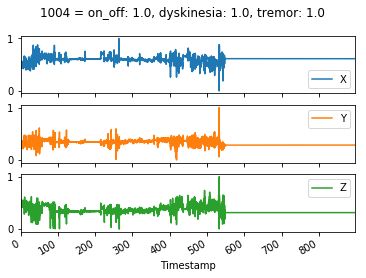

measurement_id :  5163afe8-a6b0-4ea4-b2ba-9b4501dd5912


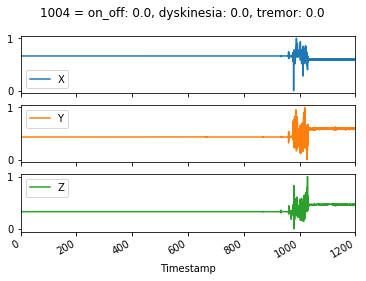

measurement_id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


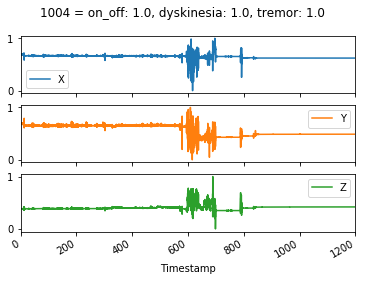

measurement_id :  3cf49c01-0499-4bad-9167-67691711204a


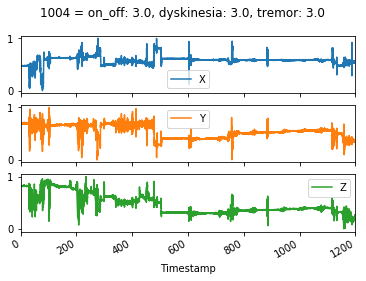

measurement_id :  4b269cc2-8f0c-4816-adbf-10c0069b8833


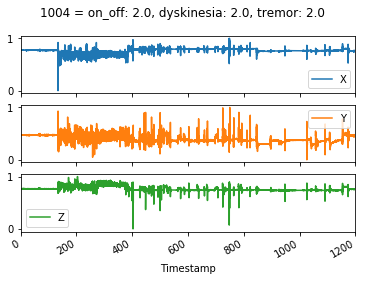

measurement_id :  4bc51b90-bfce-4231-85e1-5de3b4bc0745


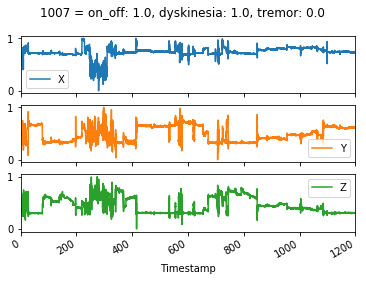

measurement_id :  3d0f965c-9d72-43d1-9369-1ea3acf963cc


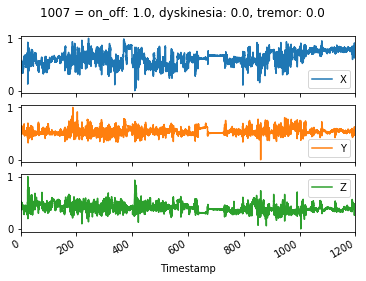

measurement_id :  2d852742-10a9-4c56-9f38-779f2cd66879


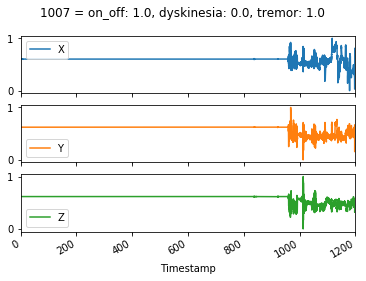

measurement_id :  4fc3c295-857f-4920-8fa5-f21bfdc7ab4f


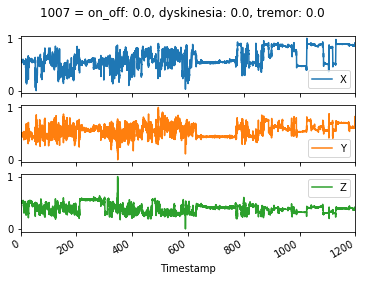

measurement_id :  2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d


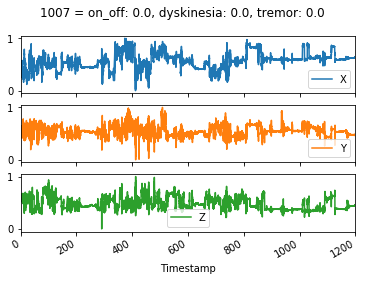

measurement_id :  db2e053a-0fb8-4206-891a-6f079fb14e3a


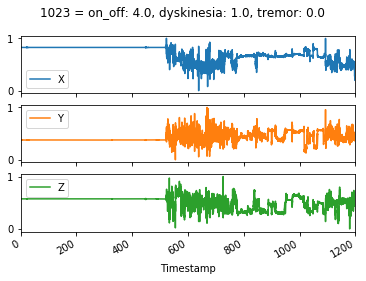

In [68]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)
#display(df_train_label)
# List of interesting measurement id we want to look at 
#list_measurement_id=[#'ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
#'db2e053a-0fb8-4206-891a-6f079fb14e3a']#,
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

list_measurement_id=['5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a',
                     'cc7b822c-e310-46f0-a8ea-98c95fdb67a1',
                     '5163afe8-a6b0-4ea4-b2ba-9b4501dd5912',
                    'db2e053a-0fb8-4206-891a-6f079fb14e3a',
                    '2d852742-10a9-4c56-9f38-779f2cd66879',
                    '2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d', # no silence should be removed
                    '3cf49c01-0499-4bad-9167-67691711204a',# no silence should be removed PAS LA?? 
                    '3d0f965c-9d72-43d1-9369-1ea3acf963cc', # PAS LA ??? 
                    '4b269cc2-8f0c-4816-adbf-10c0069b8833',
                    '4bc51b90-bfce-4231-85e1-5de3b4bc0745',
                    '4fc3c295-857f-4920-8fa5-f21bfdc7ab4f'] #bit of inactivity in the middle]


# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
display(df_train_label)

#path_no_silence_data = remove_silence(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots)


## WIP : Function to remove silence (inactivity)

In [110]:
'''
Save .csv files with silence (inactivity) removed 

Path used: 
# cis-pd.training_data.no_silence/
# real-pd.training_data.no_silence/smartphone_accelerometer/
# real-pd.training_data.no_silence/smartwatch_accelerometer/
# real-pd.training_data.no_silence/smartwatch_gyroscope/
# data_type = {'cis', 'real'}
        
Arguments:
df_train_label: Dataframe with training labels

data_real_subtype: Optional. If data_type is real, data_real_subtype needs to be provided
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    
Returns: 
path_no_silence_data: Return the path where the files are saved because it is needed
                      if we want to plot the accelerometer, for example
'''
def remove_silence(df_train_label, data_real_subtype=''):
    count = 0
    for idx in df_train_label.index: 
        df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        #print('measurement id : ', df_train_label["measurement_id"][idx])
        #display(df_train_data)
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        periods=300
        df_pct_change = df_train_data.iloc[:,-3:].pct_change(periods=periods)

        df_pct_change.columns = ['X', 'Y','Z']
        #print('pct_change measurement id : ', df_train_label["measurement_id"][idx])
        #display(df_pct_change)
        
        # Apply the treshold to the DataFrame with an AND condition, so all axis must have at least 1% of change
        # between the periods 
        #pd.options.display.max_rows = 1000
        print('----------before filter--------')
        display(df_pct_change.abs())
        
        print('WHAT IS DETECTED AS SILENCE')
        display(df_pct_change[(df_pct_change.X.abs() < 0.0002) |
                                     (df_pct_change.Y.abs() < 0.0002) |
                                     (df_pct_change.Z.abs() < 0.0002)])
        print('END OF WHAT IS DETECTED AS SILENCE')
        
        df_pct_change = df_pct_change[(df_pct_change.X.abs() >= 0.0002) &
                                     (df_pct_change.Y.abs() >= 0.0002) &
                                     (df_pct_change.Z.abs() >= 0.0002)]
        print('----------after filter--------')
        display(df_pct_change)
            
        filter_df = df_train_data[df_train_data.index.isin(df_pct_change.index.to_list())]
        
        # Counts the number of time where we had to remove inactivity from a dataframe to know how often
        # the inactivity zones appear.
        print('len(filter_df)+periods ', str(len(filter_df)+periods))
        print('len(df_train_data) ', str(len(df_train_data)))
        if len(filter_df)+periods != len(df_train_data):
            count = count + 1
            
        # To provide the name of the header for the Dataframe, we get the name of the x axis as it depends
        # on the data_type and then we insert it at the first position before the X,Y,Z axis 
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        cols_to_norm.insert(0, x_axis_data_type)

        #filter_df.plot(x='Timestamp',legend=True, subplots=True,title='allo')

        # Save the dataframe in a file with the measurement_id as the name of the file
        path_no_silence_data = data_dir+data_type+'-pd.training_data.no_silence/'+data_real_subtype+'/'
        filter_df.to_csv(path_no_silence_data+df_train_label["measurement_id"][idx]+'.csv', index=False, header=cols_to_norm)
    print('Inactivity zones were detected ', str(count) ,' times out of ', str(len(df_train_label.index)))
    return path_no_silence_data



----------before filter--------


,X,Y,Z
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


WHAT IS DETECTED AS SILENCE


,X,Y,Z
306,0.010236,0.014440,-0.000102
307,0.009512,0.015136,0.000102
318,-0.009837,-0.021118,0.000102
320,-0.014479,-0.022184,0.000102
356,0.006887,0.006278,0.000102
362,0.002325,0.001716,0.000102
367,0.001348,-0.000172,0.000408
369,-0.001868,-0.004819,-0.000102
377,-0.006999,-0.009398,0.000102
385,0.000000,-0.002143,-0.003354


END OF WHAT IS DETECTED AS SILENCE
----------after filter--------


,X,Y,Z
300,0.008790,0.011520,-0.001427
301,0.009713,0.010897,-0.003466
302,0.009506,0.010882,-0.002041
303,0.009813,0.012087,-0.001530
304,0.009031,0.012090,0.000816
305,0.010119,0.013132,-0.000611
308,0.009512,0.011936,0.003572
309,0.008331,0.009539,-0.000814
310,0.005847,0.011962,-0.001018
311,0.003416,0.006620,0.000917


len(filter_df)+periods  43249
len(df_train_data)  59805
Inactivity zones were detected  1  times out of  1
measurement_id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


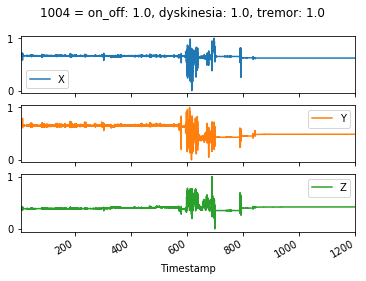

In [112]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)

# list_measurement_id=['5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a',
#                      'cc7b822c-e310-46f0-a8ea-98c95fdb67a1',
#                      '5163afe8-a6b0-4ea4-b2ba-9b4501dd5912',
#                     'db2e053a-0fb8-4206-891a-6f079fb14e3a',
#                     '2d852742-10a9-4c56-9f38-779f2cd66879',
#                     '2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d', # no silence should be removed
#                     '3cf49c01-0499-4bad-9167-67691711204a',# no silence should be removed 
#                     '3d0f965c-9d72-43d1-9369-1ea3acf963cc',  
#                     '4b269cc2-8f0c-4816-adbf-10c0069b8833',
#                     '4bc51b90-bfce-4231-85e1-5de3b4bc0745',
#                     '4fc3c295-857f-4920-8fa5-f21bfdc7ab4f'] #bit of inactivity in the middle]

list_measurement_id=['5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a']

df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

path_no_silence_data = remove_silence(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots, path_silence=path_no_silence_data)



## Visualization: Occurences of each symptoms for each subject

Nb subject_id :  2


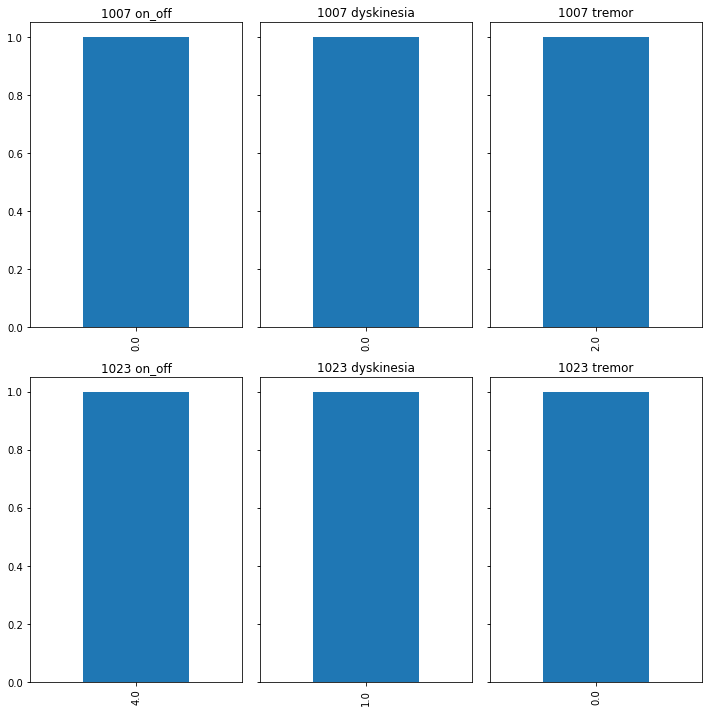

In [66]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

## KFold 

In [100]:
# KFold 
import numpy as np
from sklearn.model_selection import KFold

'''
Function that returns a list of X dataframes (X is according to the number of n_splits chosen)

The dataframes are the labels needed according to the split 

Arguments:
df_train_label: Dataframe containing the labels
n_split: Optional. The number of folds. Default: 5
subject_id: Optional. Specify a subject_id to get measurement_id only for that subject_id 
data_real_subtype: Only for REAL-PD database
'''
def get_k_fold(df_train_label, n_splits=5, subject_id=None, data_real_subtype=''):
    kf = KFold(n_splits)
    
    # Building the dataframe to split
    X = []

    #if we want the data split for one specific subject_id
    if subject_id: 
        df_train_label_subject_id = df_train_label.groupby('subject_id')
        X = df_train_label_subject_id.get_group(subject_id)
        
    # if we want to have all a split for all data no matter the subject_id
    # NOTE: I didn't make sure to have one subject_id represented in both train/test
    else: 
        for idx in df_train_label.index: 
            X.append([df_train_label["measurement_id"][idx]])
        X = pd.DataFrame(X)

    kf.get_n_splits(X)

    # Building lists of df_train_label because we have by default 5 splits, 
    # so the lists will contain 5 DataFrames with different split indices required
    list_df_train_label = list()
    list_df_test_label = list()
    split_idx=0
    for train_index, test_index in kf.split(X):
        df_train_label = X.iloc[train_index]
        df_test_label = X.iloc[test_index]

        list_df_train_label.append(df_train_label)
        list_df_test_label.append(df_test_label)
        
        #name of the file according to its database and type 
        # Example: cis_
        path_save_k_fold_dataframes = data_dir+data_type+'-pd.training_data.k_fold/'+data_real_subtype+'/'
        df_train_label.to_csv(path_save_k_fold_dataframes+str(subject_id)+'_train_kfold_'+str(split_idx)+'.csv', 
                              index=False, 
                              header=['measurement_id','subject_id','on_off','dyskinesia','tremor'])
        df_test_label.to_csv(path_save_k_fold_dataframes+str(subject_id)+'_test_kfold_'+str(split_idx)+'.csv', 
                             index=False, 
                             header=['measurement_id','subject_id','on_off','dyskinesia','tremor'])
        split_idx = split_idx + 1 
    return list_df_train_label, list_df_test_label 

### Create the K-Fold files for the CIS database 

In [99]:
# Define the data type as we have two databases 
data_type='cis'
path_train_data, df_train_label = define_data_type(data_type=data_type)
display(df_train_label)

# Group data by subject_id 
df_train_label_subject_id = df_train_label.groupby('subject_id')

# Go through the subject_id and k-fold their data
for subject_id, value in df_train_label_subject_id :
    list_df_train_label, list_df_test_label = get_k_fold(df_train_label=df_train_label, 
                                                         n_splits=5, 
                                                        subject_id=subject_id)


                                                     

#### Example on how to read data (commented as not needed right now): 

# Iterate through the DataFrame in the list list_df_train_label_train
# for df_train_label in list_df_train_label_train:
#     # Go through the measurement_id for this df_train_label split to read the training data corresponding
#     for idx in df_train_label.index: 
#         # Read the train data for this specific measurement_id 
#         # TODO: Do we want to append all of this training data together?
#         df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
#     #display(df_train_label)


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
82,0dfd3d96-7b99-4522-9bf5-c39046fcf096,1006,1.0,NaN,1.0
83,f8946f25-022a-47ba-9868-69120c94b0f2,1006,0.0,NaN,1.0
84,27c0e5f5-d68f-4c42-a327-1bce67d5d394,1006,0.0,NaN,1.0
85,eed7c640-e9a9-4c1f-a5f2-36385c73b0ea,1006,0.0,NaN,0.0
86,ec3a340a-1ce0-42be-912d-6a537474facf,1006,1.0,NaN,1.0
87,9d41900e-9a38-4a4c-9963-8fc6a54dd24c,1006,1.0,NaN,1.0
88,432acdf1-9802-4508-8a33-b75cee3636e7,1006,0.0,NaN,0.0
89,ef25ea20-65f6-4cf6-9065-6fddcbd8c165,1006,0.0,NaN,0.0
90,932197a8-dca4-4a3e-8ea6-413369bbc08d,1006,0.0,NaN,0.0
91,3f638137-e1ef-4173-8d95-f1be574cc5c4,1006,0.0,NaN,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
119,0fb89752-d513-4500-8753-d4d2fdc29907,1007,2.0,1.0,0.0
120,5f8d4735-f48b-48c4-90fe-870c17e40a8f,1007,0.0,0.0,0.0
121,d9d41941-df97-42db-be98-50fb4304b482,1007,0.0,0.0,0.0
122,5effef31-2e59-4626-a1a9-612513cfedbd,1007,1.0,1.0,0.0
123,9b1e4fe6-32ad-4b42-b8c0-3b368154763b,1007,1.0,1.0,0.0
124,79f34b92-483d-45b9-82cc-5e7db0ed68c2,1007,2.0,1.0,1.0
125,bea3e480-aa8d-4d0c-ab56-8620dca0415f,1007,0.0,0.0,0.0
126,829f4bab-393a-4614-bc6f-8205314ce09d,1007,0.0,0.0,0.0
127,121bc9e5-863b-4561-9aaf-18dc23bd1ff1,1007,1.0,0.0,0.0
128,28fbb634-2cc5-40ed-8d26-3bc1fa951f69,1007,1.0,1.0,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
418,13bdf856-0f08-4920-936d-fd6ec54ad9ff,1019,0.0,0.0,1.0
419,09557102-1f36-43b2-9c6a-9d38f6cc927c,1019,0.0,0.0,1.0
420,3a39533e-8760-4ab9-906f-88df14e1c214,1019,0.0,0.0,1.0
421,1d3701c1-4b23-4dfa-81d4-f6ca98692333,1019,0.0,0.0,1.0
422,74cae0f7-8d66-429b-9aa7-10484355de97,1019,0.0,0.0,1.0
423,ce0fd58a-e635-4e4d-af48-a46dc886a687,1019,0.0,0.0,0.0
424,5d182120-edfd-42cb-9492-4005f44ab2b3,1019,0.0,0.0,1.0
425,708f35f0-4072-4f1f-a87c-cc294af34ece,1019,0.0,0.0,0.0
426,8f0510f4-f985-487f-85a1-76dce2989172,1019,0.0,0.0,1.0
427,fec2c7d2-c800-47cf-bbe0-de2352330075,1019,0.0,0.0,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
463,44b64da8-e013-483a-a09c-809464a78d18,1020,1.0,NaN,1.0
464,36c0bc37-af10-43ac-a111-b4bacdc5d555,1020,0.0,NaN,1.0
465,e77eb7b1-76c6-4c30-8ea8-33da3bedba0e,1020,0.0,NaN,1.0
466,045e1e54-8e7e-4fba-916e-3bad2d2bc219,1020,0.0,NaN,1.0
467,c3924797-2614-4b63-9752-4aedf9fd08d4,1020,0.0,NaN,1.0
468,c9044b26-9149-4534-a449-cc6b4caf0842,1020,0.0,NaN,1.0
469,f6e5d620-b5cf-4645-9dff-f720bae604ff,1020,0.0,NaN,1.0
470,214e67c0-ec4f-4421-a4c3-dc169280f43f,1020,0.0,NaN,1.0
471,ac815814-87b7-4225-8e0d-8771bb173963,1020,0.0,NaN,1.0
472,ff9a5693-c3ab-4cee-841d-8132081db30b,1020,0.0,NaN,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
658,6f6e8e34-34b2-4d3c-80f6-04c2fd58b94a,1023,2.0,0.0,0.0
659,d8e85598-a061-42ce-82dd-632fcd8ae2b0,1023,1.0,0.0,0.0
660,2b6ebefc-487f-4186-86ac-465fbd535bce,1023,1.0,0.0,1.0
661,79748242-82d6-451c-8357-7342f37334c2,1023,3.0,1.0,1.0
662,2a490156-8e3e-49a3-98d5-7f60216990a2,1023,2.0,1.0,1.0
663,06e3ae00-795a-4c42-bf37-9d9269dea7c0,1023,0.0,0.0,0.0
664,d1dc3961-2bc3-4f19-ba53-687c815cefa9,1023,1.0,0.0,2.0
665,d959a560-f97c-4a13-9221-4cf32ca36e70,1023,1.0,1.0,1.0
666,6b707b08-2a02-44e7-915f-251f48c72183,1023,3.0,2.0,0.0
667,27ebaf2a-88a4-4811-adc5-b580ca415e8a,1023,2.0,1.0,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
764,8689ff16-f775-4ff6-9a0d-e5498484b929,1032,2.0,NaN,0.0
765,a15e8213-7137-40e6-9c74-4e0fdab4ebd5,1032,1.0,NaN,0.0
766,a59136f3-d378-4cf4-8075-ceb2d43a484c,1032,1.0,NaN,0.0
767,0642b307-2e0c-41bf-a7c4-95c5c5421611,1032,2.0,NaN,0.0
768,ee67396c-f72f-4463-a171-6b3e09ba73a1,1032,2.0,NaN,0.0
769,bccaf660-9585-466c-b8bf-7c3c0cd0027e,1032,2.0,NaN,0.0
770,fad20b91-eb61-43b4-be6a-272473f3aebb,1032,0.0,NaN,0.0
771,ea3ec657-a062-4894-9715-ba5b8704637a,1032,0.0,NaN,0.0
772,0f8a3616-0fbb-4371-9f89-e9c67212f018,1032,0.0,NaN,0.0
773,d60e2c80-21db-44f3-99f9-5ddb631435ca,1032,1.0,NaN,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
941,259621b8-62d3-4e99-a2e0-7f1792f63847,1034,3.0,2.0,1.0
942,f6fc2ef8-0cf8-42f7-98b1-76957ec5c9a9,1034,0.0,1.0,0.0
943,4de2f635-9f00-4419-bc37-2966452fd4d8,1034,1.0,1.0,1.0
944,9a03e9ae-b953-4bbd-a795-f5cb7c1c3826,1034,2.0,1.0,1.0
945,aab3d357-6efb-4287-ab57-ff2939656fba,1034,2.0,2.0,1.0
946,464ac314-6c4b-4c4a-957c-28a2339150d6,1034,0.0,4.0,1.0
947,8a4f566c-fdc8-435c-8b1d-ce5f77c75275,1034,1.0,1.0,0.0
948,d5957e8c-8899-4b85-b908-7344e6bea080,1034,0.0,3.0,0.0
949,5b27e589-0d16-4516-84d9-5a706c3c4272,1034,2.0,2.0,0.0
950,062290b1-4e87-413d-91a8-182bd8e120cf,1034,0.0,1.0,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
981,92bf2024-438a-4eda-ac49-1baa8a43619c,1038,0.0,0.0,1.0
982,68016186-0738-4099-ba1f-2c1469ece53b,1038,0.0,0.0,1.0
983,14110a8b-7e5a-452e-8e53-54053876f3ee,1038,0.0,0.0,1.0
984,0dc41684-60db-4894-a48c-4f8c364c2e0b,1038,0.0,0.0,1.0
985,060fdaca-dc34-4990-a53c-00e3dff1ca4d,1038,0.0,0.0,1.0
986,c5befc8b-85e4-430e-9e1a-3550ebba0c76,1038,0.0,0.0,1.0
987,e866dcf8-4de7-4208-845a-175222f19eaf,1038,0.0,0.0,1.0
988,c30474fd-8b70-4a4e-acc3-9f8c3d582193,1038,0.0,0.0,1.0
989,5da867cf-9198-46c8-8ae5-8944ed352be5,1038,0.0,0.0,1.0
990,9b6bc88c-9e5d-4d3d-8476-608d27a3ebe4,1038,0.0,0.0,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1188,bc339c17-0f1a-4e79-b68e-1b6884a32814,1039,4.0,0.0,NaN
1189,0e9689d7-4344-4f17-8b84-42f4b53d7ea1,1039,1.0,0.0,NaN
1190,df8f969b-5f9b-49e3-9ef8-883776e3bbf1,1039,0.0,1.0,NaN
1191,e32bbd29-6933-4bdd-9d01-d84ced190a64,1039,0.0,1.0,NaN
1192,e6434482-4e09-4021-a256-1fe7aa0768c9,1039,0.0,1.0,NaN
1193,93eac078-c686-4532-89e7-b0cd17eae12e,1039,0.0,1.0,NaN
1194,4ef75ae1-08dc-4d63-bae5-880e0341b86f,1039,0.0,1.0,NaN
1195,096e8557-3c9f-4406-8afc-afc174f6b6e6,1039,1.0,1.0,NaN
1196,2bf17d8f-53c0-4d61-957d-2495f26228a5,1039,1.0,1.0,NaN
1197,2a84b61b-5e7a-4900-b810-3d1a338ba5d2,1039,1.0,1.0,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1318,64cf6c13-7486-4c5b-892c-3249855dd371,1043,0.0,1.0,0.0
1319,d153d24c-dfa4-4a85-9142-7181b3a054d6,1043,4.0,1.0,3.0
1320,1ff4813f-2767-4fe4-8550-3f71e92d47ad,1043,1.0,1.0,1.0
1321,45ab928b-8e5c-465c-a884-17b56b29e428,1043,0.0,0.0,0.0
1322,f58a8090-a9d5-442e-ac54-bab549cda75d,1043,0.0,0.0,0.0
1323,e1052f8e-4bb3-4dc5-bd74-61283e3646ac,1043,0.0,0.0,0.0
1324,2b39005a-640d-4219-9b0b-6b6f9d579ce4,1043,0.0,0.0,0.0
1325,87d07e61-6d9c-448c-88d3-c4a12313aa4b,1043,2.0,1.0,2.0
1326,22b88456-fe8f-4138-af55-be12afca4b81,1043,3.0,3.0,3.0
1327,ad84583d-e5ae-4926-b077-531a0f7d08a9,1043,3.0,0.0,3.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1352,7027ed4d-9c95-4bf5-9aeb-d8f69a9821cf,1044,0.0,0.0,NaN
1353,88662a33-82ec-40a4-a2fc-332cff45c5af,1044,0.0,0.0,NaN
1354,83fd5aa0-e585-4200-b90c-60bb443cb2c4,1044,0.0,0.0,NaN
1355,585f9628-039a-47af-adbc-d722b717a60a,1044,0.0,0.0,NaN
1356,c1dda61b-9287-4e41-9742-fea19250bf2e,1044,0.0,0.0,NaN
1357,005685b2-3de4-469b-b673-8f937ee8196e,1044,0.0,0.0,NaN
1358,3e06f01c-a386-40c0-b452-50921b8f4e8a,1044,0.0,0.0,NaN
1359,1c3b72c7-24d5-427c-9400-be1554688a4a,1044,0.0,1.0,NaN
1360,f6fde688-844b-4c4c-8c5b-2c1709e265bd,1044,0.0,1.0,NaN
1361,d7f747bf-1abd-4149-abb1-429bc99d8de7,1044,0.0,1.0,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1424,9ca908e8-eb3f-45cc-ba3d-1e0ece544d9e,1046,NaN,NaN,1.0
1425,4d2f8946-357b-465d-a511-99ce4e8fa209,1046,NaN,NaN,0.0
1426,07f81047-9a4b-49fd-afc0-a985e2183411,1046,NaN,NaN,1.0
1427,db5a84d2-286a-4d0a-ab63-ef46266b6dc4,1046,NaN,NaN,1.0
1428,479ade9c-e30e-4968-8876-2efd6baa215f,1046,NaN,NaN,1.0
1429,567467f1-3a9f-4f83-acc3-cfe85f8cead9,1046,NaN,NaN,1.0
1430,c95093fd-5dcf-458a-96e6-77f64ffdb4c5,1046,NaN,NaN,1.0
1431,1cf10288-36ba-4446-9468-4148ce759dd4,1046,NaN,NaN,1.0
1432,94200403-2a6d-4485-b005-5f60457b2a49,1046,NaN,NaN,1.0
1433,fdc7bf0b-5861-4868-b75e-52e5586364f3,1046,NaN,NaN,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1491,43dd5795-ca7e-44f9-a31f-6879a6329f6c,1048,2.0,0.0,3.0
1492,c5788cc6-3208-4fee-aa47-2a7b7c361d59,1048,2.0,2.0,3.0
1493,abdb15f9-b1de-40d9-a7ec-b6849497cf3a,1048,1.0,3.0,3.0
1494,6be90cb7-ce71-48f1-938d-04e6dfe6ed5a,1048,1.0,3.0,3.0
1495,ee389c0c-71dd-47a9-9249-9c1bcd6c4f69,1048,1.0,3.0,4.0
1496,eef56825-940a-4c3e-aebb-60838d60869e,1048,4.0,3.0,4.0
1497,d17dc657-7704-4206-bce3-2ec1ff23b24b,1048,3.0,2.0,3.0
1498,42f57b97-ed19-4306-bd6e-01b754301ab0,1048,3.0,2.0,3.0
1499,7d869854-6b90-4ddc-adf7-b3f0496fe004,1048,1.0,2.0,3.0
1500,963043f2-d998-4503-92a3-e00f18ff339b,1048,2.0,2.0,3.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1582,e6d8e9ea-cdba-4ee4-a9d3-4d3c7016e609,1049,1.0,1.0,1.0
1583,361bad1e-a5e2-4e7f-8c68-f5fa920c0c7e,1049,1.0,1.0,1.0
1584,e9e5216b-142e-46d9-a7ba-b2cc0d6e3392,1049,1.0,1.0,1.0
1585,9ee74d58-7b74-400b-8b4c-7b0be5c9a078,1049,1.0,1.0,1.0
1586,38399e75-bd22-4e76-bc93-15c919db3573,1049,1.0,1.0,1.0
1587,22165d20-7e3d-4a11-92c5-1c4a957c6fea,1049,1.0,1.0,1.0
1588,9b488196-52f9-4139-9bb1-8b71715d49ea,1049,1.0,1.0,1.0
1589,bb1f3e97-6d74-4c57-95ec-4c314bfa00a1,1049,1.0,1.0,1.0
1590,1fc663cc-a166-4188-823b-1dc45bc2b71a,1049,2.0,1.0,2.0
1591,34056fd7-45d6-4b7a-ac01-d268b7b5f09e,1049,2.0,1.0,2.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
1664,34220f87-36ca-4e96-8c85-64987ffaf9a4,1051,0.0,NaN,NaN
1665,20d29a72-e92c-466b-a4f6-b46f7b537f49,1051,0.0,NaN,NaN
1666,99a98de2-cc71-4dcf-8dc8-06361620e4ad,1051,0.0,NaN,NaN
1667,1a9c03f2-ce97-40a1-a799-bc9ca99cc9ad,1051,0.0,NaN,NaN
1668,e6d667ad-da7d-4618-825d-0a5758a0fcbf,1051,1.0,NaN,NaN
1669,3534427e-0378-43e3-9a76-faca8ef0f7be,1051,0.0,NaN,NaN
1670,9bd9016d-ada7-4664-975e-eab4c83509a5,1051,0.0,NaN,NaN
1671,6206a202-a7e9-413a-8ca5-f959d950dc44,1051,0.0,NaN,NaN
1672,ac29e4d8-cc59-4d38-9035-0c3212f47861,1051,0.0,NaN,NaN
1673,ecb2896c-6972-41e1-a084-1c96e77df349,1051,0.0,NaN,NaN


---------- end display X----------


### Create the K-Fold Files for the REAL database

In [98]:
# To generate the files, you have to uncomment one data_real_subtype at a time and
# execute this cell 3 times for the 3 subtypes.

data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
data_real_subtype='smartwatch_accelerometer'
#data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

# Group data by subject_id 
df_train_label_subject_id = df_train_label.groupby('subject_id')

# Go through the subject_id and k-fold their data
for subject_id, value in df_train_label_subject_id :
    list_df_train_label, list_df_test_label = get_k_fold(df_train_label=df_train_label, 
                                                         n_splits=5, 
                                                         subject_id=subject_id, 
                                                         data_real_subtype=data_real_subtype)




,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
2,d3c89012-3ab9-4014-b577-61ff05e31968,hbv013,1.0,0.0,0.0
3,5c42911d-0ebd-47ba-9925-dd5ab1c0ed61,hbv013,1.0,0.0,1.0
4,235472d5-ad2e-4c76-947e-358c9d8c1280,hbv013,1.0,0.0,0.0
5,274f5bc8-2e4f-4d7c-a546-b65b7d6bd01e,hbv013,0.0,0.0,NaN
6,39cf118c-e2bb-4e3f-adb1-d200ee20e1fa,hbv013,0.0,1.0,0.0
7,ecbeea40-8770-455d-90a6-597e7f896e1b,hbv013,0.0,1.0,0.0
8,d3171986-f881-4fa8-9c61-a72a3ad3ae26,hbv013,1.0,0.0,0.0
9,96090095-7b0f-423f-ac9a-d69b7d1b638c,hbv013,0.0,1.0,0.0


-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
549,861cd882-1faf-4947-bc82-d777ed41d4ab,hbv012,NaN,NaN,0.0
550,0741fc7f-d709-4879-b9b7-1ca56e5a5021,hbv012,NaN,NaN,0.0
551,93047191-2ad3-40d5-a586-92cf6a1dbb89,hbv012,NaN,NaN,1.0
552,f4e4eed4-5470-4058-8737-8f75abe0853c,hbv012,NaN,NaN,0.0
553,aba31c29-79ef-4221-9412-156538a2fd4e,hbv012,NaN,NaN,1.0
554,288219a8-747b-4802-a1ef-cb5a5f29256b,hbv012,NaN,NaN,0.0
555,11c88a48-9074-4219-a191-e51414108ddf,hbv012,NaN,NaN,2.0
556,874e74a9-400c-4f9f-9088-af40ec2f702b,hbv012,NaN,NaN,0.0
557,b782f538-b2ae-4693-92f2-298952ab7981,hbv012,NaN,NaN,0.0
558,29bbf446-5957-4f22-8e38-756482d94fdf,hbv012,NaN,NaN,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
2,d3c89012-3ab9-4014-b577-61ff05e31968,hbv013,1.0,0.0,0.0
3,5c42911d-0ebd-47ba-9925-dd5ab1c0ed61,hbv013,1.0,0.0,1.0
4,235472d5-ad2e-4c76-947e-358c9d8c1280,hbv013,1.0,0.0,0.0
5,274f5bc8-2e4f-4d7c-a546-b65b7d6bd01e,hbv013,0.0,0.0,NaN
6,39cf118c-e2bb-4e3f-adb1-d200ee20e1fa,hbv013,0.0,1.0,0.0
7,ecbeea40-8770-455d-90a6-597e7f896e1b,hbv013,0.0,1.0,0.0
8,d3171986-f881-4fa8-9c61-a72a3ad3ae26,hbv013,1.0,0.0,0.0
9,96090095-7b0f-423f-ac9a-d69b7d1b638c,hbv013,0.0,1.0,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
372,91bd328e-e7b6-4de8-b792-acfbfcd68cb9,hbv014,1.0,NaN,NaN
373,17a393a9-9d2e-44cf-96f8-2d8c9838809b,hbv014,1.0,NaN,NaN
374,d89fb74f-5241-4388-9bcb-409b574c5f3a,hbv014,1.0,NaN,NaN
375,415d3460-11af-4d5b-bc5d-e082a3306513,hbv014,1.0,NaN,NaN
376,a952f863-f219-407e-a546-4579b20b022e,hbv014,1.0,NaN,NaN
377,edea9cf8-4353-4742-b8d7-1baf09e2139b,hbv014,1.0,NaN,NaN
378,c0d5ead3-f048-46c9-8ee2-481fdbcfa56d,hbv014,0.0,NaN,NaN
379,a7448017-beb4-4308-b8ab-9f747e8684a4,hbv014,0.0,NaN,NaN
380,6f0e2580-56ec-4743-9356-d3e4d9a0aee5,hbv014,NaN,NaN,NaN
381,3444762b-d220-44cd-94e0-838c1f5e29e5,hbv014,0.0,NaN,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
112,6bcdf1e1-6210-4b3b-a740-be5d921af889,hbv017,NaN,0.0,NaN
113,ebd6c616-0e16-4c8c-8358-aeb2e4326764,hbv017,NaN,0.0,NaN
114,afe7209e-ac7d-4be9-b100-decb9e81cd42,hbv017,NaN,1.0,NaN
115,db9b6763-6d0c-4d8a-b27c-104ebec29dd3,hbv017,NaN,0.0,NaN
116,97642041-eeff-409c-b138-ff2ec19af5a2,hbv017,NaN,0.0,NaN
117,1095c912-48ac-44c8-a8a1-0d1c29d0361b,hbv017,NaN,1.0,NaN
118,a5b6a1de-a75b-4169-aab8-79ba10f95f46,hbv017,NaN,0.0,NaN
119,105b7cc6-f580-4849-8e49-7c95463350bd,hbv017,NaN,1.0,NaN
120,bd3defa5-af6a-4510-bc0c-4dbbe87f1559,hbv017,NaN,1.0,NaN
121,75b3cd77-6033-4fa6-9bc6-71e334ee3ade,hbv017,NaN,1.0,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
420,99dffbb5-0cc9-480c-8aa3-6bc90fc3aeb7,hbv018,NaN,1.0,NaN
421,6a2270ac-3c3d-4bfc-a5e4-e0dd03597820,hbv018,NaN,1.0,NaN
422,c43a1589-b508-4436-b23f-07e91abdeb02,hbv018,NaN,1.0,NaN
423,2356af8f-80ec-4def-9a58-c3db6f0f202a,hbv018,NaN,1.0,NaN
424,57779b31-49e8-4c91-9e00-693e1140de85,hbv018,NaN,1.0,NaN
425,d45c7c53-042a-4aa9-a3dc-a02a42f22f44,hbv018,NaN,1.0,NaN
426,2657d1b0-ac48-4e0a-9f6b-eb18cacc2f40,hbv018,NaN,1.0,NaN
427,a5be6e50-4a46-46e7-9b4e-13eb73531e0f,hbv018,NaN,1.0,NaN
428,719380dd-2960-44ab-886e-07c2970ad4dd,hbv018,NaN,0.0,NaN
429,e2258da1-127a-4434-b371-7be2e5a88684,hbv018,NaN,0.0,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
492,a63c69a6-3c62-45ea-a802-7e1613a3bdc4,hbv022,1.0,NaN,0.0
493,a5b47d69-b8b1-4e42-a1a5-fbcc60a91b9a,hbv022,1.0,NaN,0.0
494,b0f37ef8-12ec-4d39-8729-63bd700d3b9b,hbv022,0.0,NaN,NaN
495,37811a72-987e-44e6-b817-d26bdb0b2944,hbv022,1.0,NaN,0.0
496,617fa957-c101-4fae-a34c-f740000e7a74,hbv022,1.0,NaN,0.0
497,4903769a-394e-4fa7-97c9-7bd1fd410850,hbv022,0.0,NaN,0.0
498,5021d2db-723a-4c05-8439-317ec320aded,hbv022,1.0,NaN,0.0
499,7a554795-dfbb-4f27-9ba9-b50c127b7414,hbv022,0.0,NaN,0.0
500,abce9527-e737-426d-9e96-a0a727e8434d,hbv022,0.0,NaN,0.0
501,3510b342-acf3-4d0d-83f4-a9964cf3966c,hbv022,1.0,NaN,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
181,202ec734-1c38-41d5-a890-df7c50f296bf,hbv023,NaN,NaN,2.0
182,a4901f98-811a-495a-9e8c-4aece99dafb2,hbv023,NaN,NaN,2.0
183,3a507fed-f483-4543-8242-350ae1fbd894,hbv023,NaN,NaN,2.0
184,bc18d475-7b09-4f74-96a9-37a3af36e7ac,hbv023,NaN,NaN,2.0
185,b5098d2c-fdec-485c-a855-bd5cd7ff68ea,hbv023,NaN,NaN,2.0
186,46dd3d61-b81e-408e-ac35-4538ed0aa9c7,hbv023,NaN,NaN,2.0
187,82cf870c-69a7-4efe-ab9e-117545e08113,hbv023,NaN,NaN,2.0
188,b0ad62d7-d02f-46b3-9bb4-4c6e6650837b,hbv023,NaN,NaN,2.0
189,4f8253d3-1f29-4ab4-b660-cf8a33b920e1,hbv023,NaN,NaN,2.0
190,2eabd596-f1e0-4b4b-839e-cd7867219735,hbv023,NaN,NaN,2.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
68,e803a862-cd7c-405a-92aa-409f97d6af6e,hbv038,1.0,NaN,3.0
69,8fe9726b-a493-4c0b-848f-6c2b8bf6a58e,hbv038,1.0,NaN,1.0
70,b3ec05e9-bbad-40b5-bceb-81bc958ca833,hbv038,0.0,NaN,1.0
71,9a2236ba-4eb6-47d8-b7b5-120985f6f2be,hbv038,1.0,NaN,1.0
72,0af9da02-6b27-4d27-9940-575d31dd74bd,hbv038,1.0,NaN,3.0
73,4974a2d3-0520-4c03-99ec-f00f06d21e33,hbv038,0.0,NaN,1.0
74,495f4e2f-27e4-4fc7-9df4-4269964c179d,hbv038,0.0,NaN,1.0
75,f11d7787-4b87-4101-9bac-86203b701fc6,hbv038,0.0,NaN,1.0
76,7f8b92cd-11ef-406b-b460-655ad7b73e16,hbv038,0.0,NaN,1.0
77,2daabd36-1707-473b-93f1-265ce6b7999e,hbv038,0.0,NaN,1.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
455,5f6ec7b4-2374-4309-9349-14af6d2eebf2,hbv043,0.0,1.0,NaN
456,22b9cab0-aadd-4d9f-9d03-6c85c85be824,hbv043,0.0,1.0,NaN
457,ead7c4df-53fc-493e-be19-39e5c269f003,hbv043,1.0,2.0,NaN
458,f71ba377-2f59-4605-ae3f-8221d2120c7f,hbv043,1.0,2.0,NaN
459,a6a309e7-2450-4ba5-89d3-ce2608989c9a,hbv043,0.0,0.0,NaN
460,c889b055-0579-4ce8-b7f4-5832d7d83bcc,hbv043,0.0,0.0,NaN
461,6792f751-13bb-475c-9591-a6048f0f7353,hbv043,1.0,2.0,NaN
462,90b65bce-ca6c-4c07-bdbe-58d507702002,hbv043,0.0,0.0,NaN
463,2db21109-b138-4907-9087-994d0c03f71f,hbv043,0.0,1.0,NaN
464,64080944-b52a-479e-94f9-ee26440b23f3,hbv043,1.0,0.0,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
227,8da2e6d4-ee80-43dd-b589-922520b98fd0,hbv051,1.0,NaN,NaN
228,f9aa7d5d-c2a4-4b69-9fe3-231386649397,hbv051,1.0,NaN,NaN
229,a3476076-065d-4fb8-89af-320f553a2399,hbv051,0.0,NaN,NaN
230,50306e2a-48cc-4750-b761-f6dee9e53748,hbv051,0.0,NaN,NaN
231,b74b8b47-d0a5-47b3-82a9-34c9a20bc5b6,hbv051,0.0,NaN,NaN
232,9f9038d9-44c2-4ec3-91ba-1cc4820901cd,hbv051,0.0,NaN,NaN
233,8e885a17-89bd-448e-bca1-75544343f450,hbv051,0.0,NaN,NaN
234,944a4dac-c485-4df0-a4f0-d0fc8a6f0cfb,hbv051,0.0,NaN,NaN
235,64a46f8c-f19b-4d08-8e6f-262d5ec39b2a,hbv051,0.0,NaN,NaN
236,0e4c954f-e391-41ac-a4bd-1d1d4f655b5d,hbv051,0.0,NaN,NaN


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
312,31e1ab14-0d24-4eed-ab97-26bfdc2b257a,hbv054,NaN,0.0,0.0
313,cfde5c95-82b9-4ec7-9f87-326a7a79785b,hbv054,NaN,0.0,0.0
314,e8b0e9d3-b000-4e86-860f-06528c16c3ed,hbv054,NaN,0.0,0.0
315,f7b3c9ac-32d4-482e-a1a4-ed407c5eb210,hbv054,NaN,0.0,0.0
316,ccf9e4aa-f3eb-4658-a8de-2d812245baa3,hbv054,NaN,0.0,0.0
317,17889ac7-23e5-41dd-a374-9ad7a99f1569,hbv054,NaN,0.0,0.0
318,f185bdf4-00af-4c2a-b917-b0c4ab786785,hbv054,NaN,0.0,0.0
319,ee43a968-89e4-4805-a19e-8784a5cb1c28,hbv054,NaN,1.0,0.0
320,c2d7f68c-fe2e-458a-8c19-bc6081f1ee27,hbv054,NaN,0.0,0.0
321,9d9f3d00-ca89-4c43-958b-e9ab606769a2,hbv054,NaN,0.0,0.0


---------- end display X----------
-------- display X --------


,measurement_id,subject_id,on_off,dyskinesia,tremor
268,2edf81d8-7d66-4d68-8895-695358004cca,hbv077,0.0,NaN,NaN
269,a2490c1c-d9d5-4e55-8515-d589d6e8d2e6,hbv077,0.0,NaN,NaN
270,a3b27078-8a57-4eff-b1e9-820e293c9da5,hbv077,0.0,NaN,NaN
271,3ec5b419-dcb9-4636-bb40-bdc670ab7b94,hbv077,0.0,NaN,NaN
272,dacb9c6b-dd15-4547-9c9e-a6d00248b9ca,hbv077,0.0,NaN,NaN
273,ff1db97b-8505-4c47-9a71-eb7f595519b0,hbv077,1.0,NaN,NaN
274,b1fd96b8-c832-4519-8e9f-929cbade66a2,hbv077,1.0,NaN,NaN
275,cf841bf8-0082-4ea3-999f-1f43e39a8dc6,hbv077,NaN,NaN,NaN
276,fd0fc719-4ca1-4b52-a06b-4d0a3bc0900c,hbv077,0.0,NaN,NaN
277,d25782de-83c0-4f73-adfb-7637d8a7d39a,hbv077,1.0,NaN,NaN


---------- end display X----------


# REAL-PD Database

This database, originally named "Parkinson@Home" is renamed to "Real-PD" for this challenge. The study was made over 2 weeks, with at home monitoring. 

The devices used are an android phone, a motorolla watch. 
- `smartwatch_accelerometer` and `smartwatch_gyroscope` : Motorolla Watch
- `smartphone_accelerometer` : Android phone 

-> Question: so is the smartwatch & smartphone accelerometer should measure the same movements? 

The REAL-PD database has many missing values. 

The subject_id `hbv013` is the only one without missing data. Other patients all have at least one missing symptom (`diskenisia`, ) or two (`on/off and tremor`, `on_off and dyskinesia`, `dyskinesia and tremor`) missing.

Measurements id with no data (`on_off`, `dyskinesia` and `tremor` are all missing):
- `b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8`
- `b598c177-4e38-4ea8-8543-bd8f7e580f96`
- `cf841bf8-0082-4ea3-999f-1f43e39a8dc6`
- `b1e15f8a-109f-459b-ba87-46899240ee66`
- `6f0e2580-56ec-4743-9356-d3e4d9a0aee5`
- `773536f6-9b70-43d0-b099-5d167d74924a`
- `54a0e841-ad45-4ba7-ac83-1785c5f7748b`
- `cd9ed2e2-7e04-44c7-b041-7788f133c193`
- `a6954a91-338b-4523-9e4a-5e69a8fac206`

The 3 symptoms are reported as follows in this dataset: 
- `on_off = {0,1}`
  - `Off` : 0 (medication is wearing off) 
  - `On` : 1 (medication is working)
  
- `dyskinesia = {0,1,2}`
  - Without dyskinesia: 0 
  - Non-troublesome dyskinesia: 1 
  - Severe dyskinesia: 2 
  
- `tremor = {0,1,2,3,4}` 
The description of the database mentions `tremor` is rated from 0 to 4 according to its severity, but from all the data, the maximum value of `tremor` recorded is 3. 

Data:
- ancillary
- clinical : UPDRS evaluation score 
- demographics : #TODO


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
13,e07708ff-7b8d-4070-af70-3aa81423ab5b,hbv013,0.0,0.0,0.0
15,99af8d14-cd09-4107-9502-355378ba4e08,hbv013,0.0,0.0,1.0
18,9e43840b-dd89-498b-af1a-a62896a4d5d9,hbv013,1.0,0.0,1.0
32,e391f546-bf8a-46c7-a16c-95bc02f40629,hbv013,1.0,0.0,0.0
222,5b4c7c81-659d-40ea-a1fd-59622074fd10,hbv023,NaN,NaN,2.0


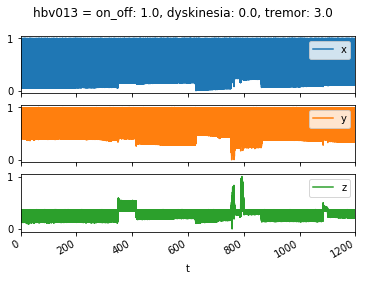

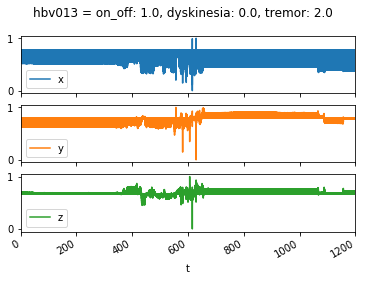

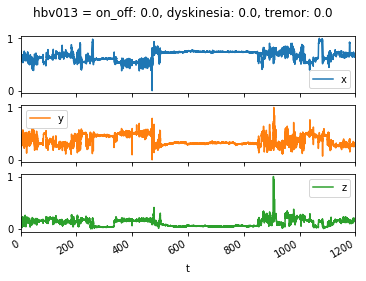

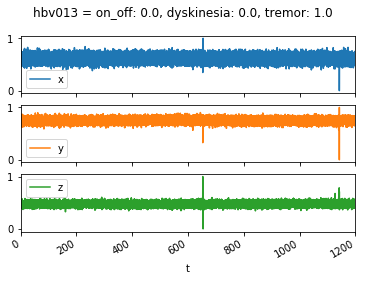

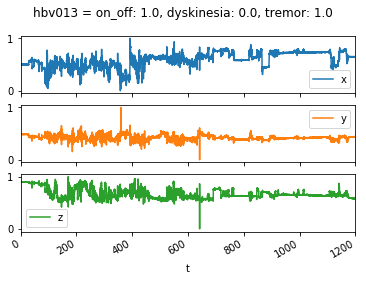

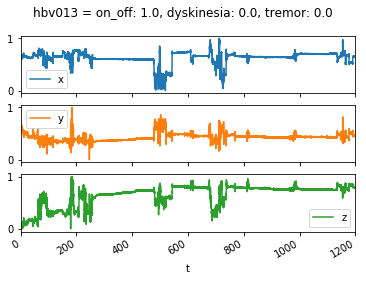

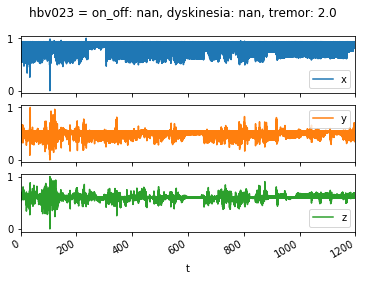

In [70]:
data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
data_real_subtype='smartwatch_accelerometer'
#data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=['5b4c7c81-659d-40ea-a1fd-59622074fd10','ee053d95-c155-400d-ae42-fe24834ad4a9',
'ce51ee31-8553-4321-9f83-8cd3dabe2f66',
'e07708ff-7b8d-4070-af70-3aa81423ab5b',
#'7d3f4b7a-167f-4a26-9062-94ce9d8794c1',
'99af8d14-cd09-4107-9502-355378ba4e08',
#'7d5ac31a-cb53-40f7-8188-0b13724ea55c',
'9e43840b-dd89-498b-af1a-a62896a4d5d9',
'e391f546-bf8a-46c7-a16c-95bc02f40629']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
#display(df_train_label)

###  Plot the accelerometer data 
# Path example: /home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/real/smartwatch_gyroscope/
path = path_save_accelerometer_plots+'/'+data_type+'/'+data_real_subtype+'/'
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path)


In [71]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

Nb subject_id :  2


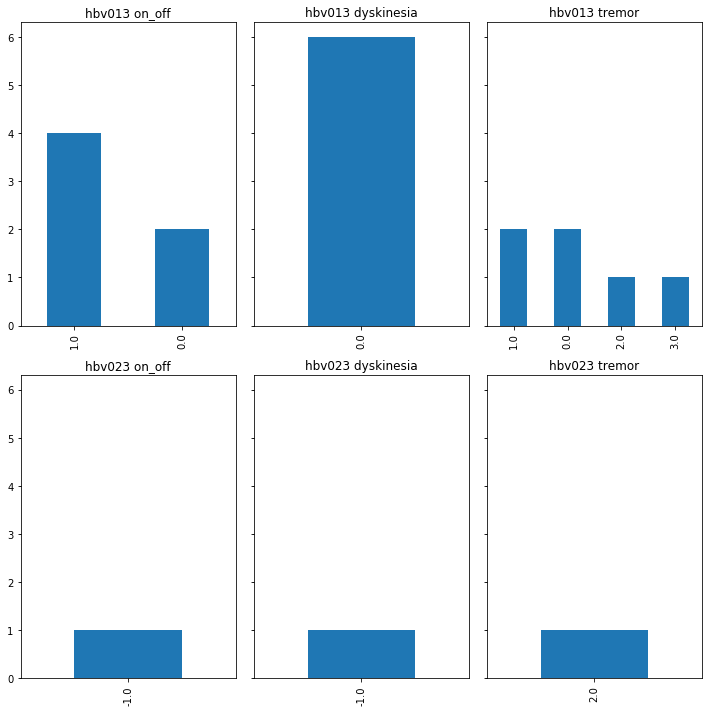

In [72]:
# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

# Comparing both databases


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">CIS-PD</th>
    <th class="tg-0pky">REAL-PD</th>
  </tr>
  <tr>
    <td class="tg-0pky"># of subject_id training</td>
    <td class="tg-c3ow">16</td>
    <td class="tg-c3ow">12</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of female training</td>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">7</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of male training</td>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">5</td>
  </tr>
  <tr>
    <td class="tg-0pky">Age average (std deviation)</td>
    <td class="tg-c3ow">62.8125 (10.857)</td>
    <td class="tg-c3ow">59.833 (5.828)</td>
  </tr>
</table>



In [73]:
# DataFrame for specified subject_id
#display(df_train_label_subject_id.get_group('hbv013'))

#print(display(df_train_label_subject_id.get_group('hbv013')['tremor'].value_counts()))

# Graphs for a specific subject_id the 3 symptoms 
# df_train_label_subject_id.get_group('hbv014')['tremor'].value_counts().plot(kind='bar', title='tremor')
# df_train_label_subject_id.get_group('hbv014')['dyskinesia'].value_counts().plot(kind='bar', title='dys')
# df_train_label_subject_id.get_group('hbv014')['on_off'].value_counts().plot(kind='bar', title='on_off')


# Tests & Drafts, back-up space that's not important, just notes

In [74]:
20*60/59848

0.02005079534821548

In [75]:
# Change the default option to display all row with display(DF)
# pd.set_option('display.max_rows', 1000)

### How to filter a DataFrame

In [76]:
# Analysis of the data to find edge cases 


# Create variable with TRUE if nationality is USA
dys = df_train_label['dyskinesia'] > 1

# Create variable with TRUE if age is greater than 50
tre = df_train_label['on_off'] > 0

# Select all cases where nationality is USA and age is greater than 50
df_train_label[dys & tre]

,measurement_id,subject_id,on_off,dyskinesia,tremor


### Playing around with pct_change function to try and remove_silence

In [30]:
# df_pct_change = df_train_data.iloc[:,-3:].pct_change(periods=5)
# #df_pct_change = df_train_data['X'].pct_change(periods=5)
# df_pct_change.columns = ['X', 'Y','Z']
# print('pct_change measurement id : ', df_train_label["measurement_id"][idx])
# display(df_pct_change)
# df_pct_change = df_pct_change[df_pct_change > 0.01]
        
cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [1,1,2,3,4,5,6],
        'Price2': [2,3,4,5,6,7,8]
        }

df = pd.DataFrame(cars, columns = ['Brand', 'Price','Price2'])
display(df)

display(df.iloc[:,-2:])

display(df.iloc[:,-2:].pct_change(periods=1))

df = df.iloc[:,-2:].pct_change(periods=1, fill_method='ffill')

df_pct_change = df[(df['Price'] > 0.25) & (df['Price2'] > 0.3)]
print('------------')
display(df_pct_change)
print('------------')
#display(df['Price'].pct_change(periods=1))

#display(df['Price','Price2'].pct_change(periods=2))

display(df['Price'].pct_change(periods=5))

,Brand,Price,Price2
0,Honda Civic,1,2
1,Toyota Corolla,1,3
2,Ford Focus,2,4
3,Audi A4,3,5
4,Toyota Corolla,4,6
5,Ford Focus,5,7
6,Audi A4,6,8


,Price,Price2
0,1,2
1,1,3
2,2,4
3,3,5
4,4,6
5,5,7
6,6,8


,Price,Price2
0,NaN,NaN
1,0.000000,0.500000
2,1.000000,0.333333
3,0.500000,0.250000
4,0.333333,0.200000
5,0.250000,0.166667
6,0.200000,0.142857


------------


,Price,Price2
2,1.0,0.333333


------------


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    inf
Name: Price, dtype: float64